# **Starbucks Ratings Text Classification with LSTM**

In an era dominated by online reviews and social media, understanding customer sentiment is important for businesses striving to enhance their products and services. Starbucks, as a global coffeehouse chain, receives vast amounts of feedback from customers through various platforms. Analyzing these textual reviews can provide valuable insights into customer satisfaction and preferences.

In this notebook, we'll explore how to classify Starbucks ratings based on online text reviews using Long Short-Term Memory (LSTM) networks, a type of recurrent neural network (RNN) well-suited for sequential data analysis.

## Dataset

We'll be working with a [dataset](https://www.kaggle.com/datasets/yacharki/yelp-reviews-for-sa-finegrained-5-classes-csv. ) containing textual reviews of Starbucks from various customers, along with their corresponding star ratings. This dataset serves as a rich source of information for training our text classification model.

## Objective

The primary objective of this project is to develop accurate text classification model capable of accurately predicting star ratings based on the content of customer reviews. By using natural language processing (NLP) techniques and deep learning with LSTM, we aim to automate the process of sentiment analysis for Starbucks reviews.

## Methodology

We'll use PySpark as part of the analysis. Our approach to Starbucks ratings text classification involves the following steps:

1. **Data Preprocessing**: We'll preprocess the textual reviews by tokenizing the text, removing stopwords, performing stemming or lemmatization, and encoding the text into numerical representations suitable for input into the LSTM model.

2. **Model Architecture**: We'll design an LSTM-based neural network architecture for text classification. LSTM networks are particularly effective for capturing long-range dependencies in sequential data, making them well-suited for analyzing natural language text.

3. **Model Training**: Using the preprocessed data, we'll train our LSTM model on the reviews and their corresponding star ratings. During training, the model will learn to map input text sequences to their respective star rating categories.

4. **Prediction**: Finally, we'll use our trained LSTM model to predict star ratings for new textual reviews of Starbucks. This capability enables businesses to automate the analysis of customer sentiment and make data-driven decisions to improve customer satisfaction and product quality.

5. **Model Evaluation**: We'll evaluate the performance of our trained model using metrics such as accuracy, precision, recall, and F1-score on a held-out validation dataset. This step ensures that our model generalizes well to unseen reviews and effectively classifies them into the correct star rating categories.

By the end of this notebook, you'll have a solid understanding of how LSTM networks can be applied to classify textual reviews and predict star ratings for Starbucks, facilitating deeper insights into customer sentiment and preferences.

Let's get started!

# Installing libraries

In [1]:
# pip install spark

In [2]:
pip install pyspark tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=530e6524f9dd675d002db19637c4eca794226e917897a49a3c6ddf79d4ad4c9c
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


# Import Libraries
Importing the necessary libraries for text processing and deep learning

In [3]:
# Import necessary libraries
import numpy as np #for numerical calculations
import pandas as pd #for working with dataframes
from pyspark.sql import SparkSession #for starting spark session
from pyspark.ml.feature import Tokenizer
from keras.preprocessing.text import Tokenizer as KerasTokenizer #for deep learning
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
import tensorflow
import sklearn #for modelling
import seaborn as sns #for plotting
import matplotlib.pyplot as plt

# Create a Spark Session
Using Pyspark to create a Spark session called, "MySession". This is important for working in the Spark environment.
- "SparkSession.builder" is used to build and set preferences for the Spark Session
- appName() is used to set the desired name of the Spark session
- getOrCreate() is used to create a brand new Spark session or retrieve an already existing Spark session.

In [4]:
spark = SparkSession.builder \
.appName('MySession') \
.master('local[*]') \
.config('spark.sql.execution.arrow.pyspark.enabled', True) \
.config('spark.sql.session.timeZone', 'UTC') \
.config('spark.driver.memory','32G') \
.config('spark.ui.showConsoleProgress', True) \
.config('spark.sql.repl.eagerEval.enabled', True) \
.getOrCreate()

# Load Data
Reading the CSV file into the Spark DataFrame using read.csv method.
- "header = True" means that the data has column headings and that these headings should be translated from the CSV file into the DataFrame.

In [5]:
df = spark.read.csv("train.csv", header=True)

# Data Exploration

Exploring the data to check for datatypes, null values and imbalanced data.

## View Dataframe
Viewing the Spark dataframe using the `.show()` method. By default, this method shows 20 rows of data.
- The Dataframe has three columns: 'class_index', 'review_title' and 'review_text'.

In [14]:
df.show()

+-----------+--------------------+
|class_index|         review_text|
+-----------+--------------------+
|          5|dr. goldberg offe...|
|          2|Unfortunately, th...|
|          4|Been going to Dr....|
|          4|Got a letter in t...|
|          1|I don't know what...|
|          5|Top notch doctor ...|
|          5|Dr. Eric Goldberg...|
|          1|I'm writing this ...|
|          2|Wing sauce is lik...|
|          3|Decent range some...|
|          1|Owning a driving ...|
|          1|This place is abs...|
|          4|I drove by yester...|
|          2|After waiting for...|
|          5|"This place was D...|
|          5|Can't miss stop f...|
|          5|"This place shoul...|
|          5|"Old school.....t...|
|          5| Good fish sandwich.|
|          5|After a morning o...|
+-----------+--------------------+
only showing top 20 rows



## Checking Datatypes
To check the datatypes of the dataframe, I will covert it to a Pandas dataframe, using `toPandas()`.
- `toPandas()` allows you to convert a Spark dataframe to a Pandas dataframe enable you to perform pandas functions on the dataset.
- Then using the Pandas property, `dtypes`, I will get the datatypes of the converted Pandas dataframe

In [15]:
#check dtype
df.toPandas().dtypes

class_index    object
review_text    object
dtype: object

All three columns are of the 'object' type.
- 'class_index' is the target variable.
- ' review_text' is the independent variable column'

The 'class_index' variable will be used in the classification. Therefore, 'class_index will have to be converted to a numeric type'

## Checking Balanced Data
Using Seaborn to create a barplot of the "class_index" data, to check whether the 5 classes are equally distributed.

<Axes: >

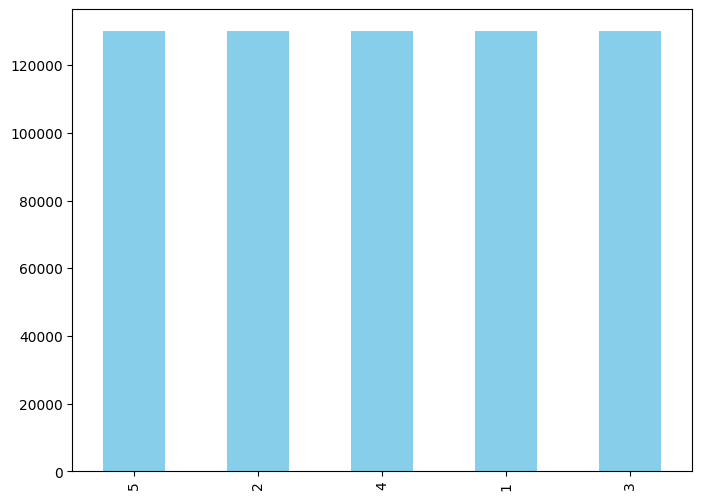

In [16]:
import matplotlib.pyplot as plt
# Extracting the 'class_index' column and convert to a Pandas DataFrame
ci=df.select("class_index").toPandas()
# Calculating the count for each class_index
category_counts = ci['class_index'].value_counts()
# Plotting the bar plot
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color='skyblue')

The histogram show the data to be balanced. Therefore, there is no need to apply methods for balancing the data.

In [17]:
df.toPandas().shape

(650000, 2)

## Checking null Values

In [18]:
df.toPandas().isnull().any()

class_index    False
review_text    False
dtype: bool

There are no missing values

# Data Pre-Processing

Addressing issues in the data, such as the categorical target variable. I will convert the categorical target variable to a numeric one.

## Change Data to Numeric
Change the datatype of the target variable 'class_index' to an integer.
- I will start by importing IntegerType from `pyspark.sql.type`. This is important for casting the column into the integer type.
- Using `.cast(Integer())` I will select the 'class_index' column from the dataframe and cast it into the integer type.
-Using withColumn, I replace the existing contents in the 'class_index' column with the contents of the new datatype.
- The resulting numbers are in the range of 1 to 5. For the sake of classification in which the indice start at 0, I will minus 1 from each number, so that they are from the range (0 to 4).

In [ ]:
from pyspark.sql.types import IntegerType
df = df.withColumn("class_index", df["class_index"].cast(IntegerType()))

In [ ]:
from pyspark.sql.functions import col
df = df.withColumn("class_index", col("class_index") - 1)


Displaying the new target column values:

In [ ]:
df.show(5)

+-----------+--------------------+
|class_index|         review_text|
+-----------+--------------------+
|          4|dr. goldberg offe...|
|          1|Unfortunately, th...|
|          3|Been going to Dr....|
|          3|Got a letter in t...|
|          0|I don't know what...|
+-----------+--------------------+
only showing top 5 rows



Viewing the new data types:

In [ ]:
df.dtypes

[('class_index', 'int'), ('review_text', 'string')]

# Convert Spark dataframe to Pandas dataframe

In order to be able to continue evaluating the data, I will convert the dataframe to pandas

In [ ]:
df = df.toPandas()

# Subset the Data
Creating a subset of the input data which is 10% smaller than the input data, for faster calculations and better memory usage

In [ ]:
data_pd = df.sample(frac=0.1, random_state=42)  # random_state for reproducibility
# Print the first few rows of the subset
data_pd.head()

,class_index,review_text
177288,0,"First of all i'm not a big fan of buffet, i tr..."
238756,1,Thanks Yelp. I was looking for the words to de...
604225,2,Service was so-so. They were receiving a deliv...
2838,2,Stamoolis Brothers is one of the Strip Distric...
586957,0,"""I want to give a 2 stars because the service ..."


Clustering the text column into 5 clusters to see which words commonly occur together. I did this using a combination of wordcloud and K-means clustering. This code was adapted from [Machine Learning Geek](https://machinelearninggeek.com/text-clustering-clustering-news-articles/) and [GitHub.com/lucas-de-sa](https://github.com/lucas-de-sa/national-anthems-clustering/blob/master/Cluster_Anthems.ipynb)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


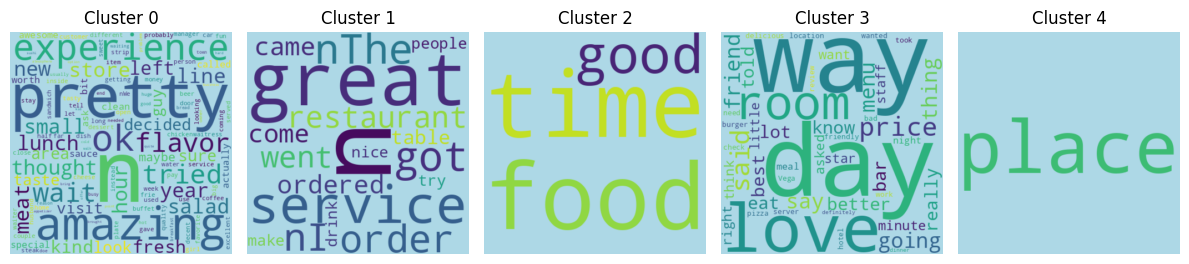

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from wordcloud import WordCloud
from sklearn.cluster import KMeans
import numpy as np


# Preprocessing the text
# Removing stopwords and creating a bag of words
stop_words = ENGLISH_STOP_WORDS
wordcloud_text = ' '.join(data_pd['review_text'])
wordcloud = WordCloud(width=800, height=400, background_color='lightblue', stopwords=stop_words).generate(wordcloud_text)

# Clustering the words
wordcloud_words = list(wordcloud.words_.keys())
word_embeddings = np.array([wordcloud.words_[word] for word in wordcloud_words])
num_clusters = 5  # Number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(word_embeddings.reshape(-1, 1))

# Assigning cluster labels to each word
df_clusters = pd.DataFrame({'word': wordcloud_words, 'cluster_label': kmeans.labels_})

# Displaying the word cloud with cluster labels
plt.figure(figsize=(12, 8))
for cluster_label in range(num_clusters):
    words_in_cluster = ' '.join(df_clusters[df_clusters['cluster_label'] == cluster_label]['word'])
    wordcloud_cluster = WordCloud(width=400, height=400, background_color='lightblue').generate(words_in_cluster)

    plt.subplot(1, num_clusters, cluster_label+1)
    plt.imshow(wordcloud_cluster, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Cluster {cluster_label}')

plt.tight_layout()
plt.show()

# Define X and y

Splitting the dataset into text and label data. X is the text data and y is the label data

In [ ]:
X = data_pd["review_text"]
y = data_pd["class_index"]

# Text Pre-processing

## Remove Punctuation

Removing punctuation from the text column to allow for easier text processing.

In [ ]:
import string
data_pd['No Punct'] = [''.join(c for c in text if c not in string.punctuation) for text in data_pd['review_text']]

#Code adapted from: https://stackoverflow.com/a/16051020/21417138

Viewing the data without punctuation:

In [ ]:
data_pd

,class_index,review_text,No Punct
177288,0,"First of all i'm not a big fan of buffet, i tr...",First of all im not a big fan of buffet i trie...
238756,1,Thanks Yelp. I was looking for the words to de...,Thanks Yelp I was looking for the words to des...
604225,2,Service was so-so. They were receiving a deliv...,Service was soso They were receiving a deliver...
2838,2,Stamoolis Brothers is one of the Strip Distric...,Stamoolis Brothers is one of the Strip Distric...
586957,0,"""I want to give a 2 stars because the service ...",I want to give a 2 stars because the service s...
...,...,...,...
60170,4,One of my favorite non-AYCE sushi places. It'...,One of my favorite nonAYCE sushi places Its s...
339909,1,I'm so disappointed. This restaurant had good ...,Im so disappointed This restaurant had good re...
426414,3,"For what it is, this was great. American chin...",For what it is this was great American chines...
157251,0,"""Nope. Nope. NOPE. \nWhen I moved here, I got ...",Nope Nope NOPE nWhen I moved here I got the Oh...


## Tokenize Data
Tokenization is the breaking up of a phrase, sentence or paragraph into smaller units such as individual words (called tokens), that a program can easily work with. Without tokenization, it's impossible to carry out analysis of text data.

Keras Tokenizer is used to tokenize the data.
- Keras tokenizer assigns each word a unique integer id after tokenization.
- The Tokenizer converts the text sequences into sequences of integers using the vocabulary. Each word in the text is replaced with its integer ID, creating a sequence of integers representing the original text.
- The Tokenizer can also pad or truncate the sequences to a fixed length, ensuring that all sequences have the same length. This is important for training LSTMs, as inputs must have consistent dimensions.

- The Tokenizer provides options to handle out-of-vocabulary words that are not present in the vocabulary. An approach is to replace them with a special "out-of-vocabulary" token.

### **Tokenizer Parameters**

Thus, the tokenizer makes use of the following parameters

1. **'max_length' (Max Sequence Length):**
   - 'max_length' is the maximum length of a sequence  after tokenization and padding. Sequences longer than this will be truncated, and sequences shorter than this will be padded.

2. **'trunc type' (Truncation Type):**
   - It specifies whether truncation should be done at the beginning or end of the sequence if it exceeds the 'max_length'. In this analysis, 'post' indicates truncation at the end of the sequence.

3. **'padding_type' (Padding Type):**
   - It determines whether padding should be added at the beginning or end of the sequence. In this analysis, 'post' indicates padding at the end of the sequence.

4. **'oov_token' (Out-of-Vocabulary Token):**
   - The out-of-vocabulary token is a special token used to represent words that are not present in the vocabulary. It is used during tokenization to handle out-of-vocabulary words.

5. **'vocab' (Vocabulary Size):**
   - 'vocab' specifies the desired vocabulary size, that is, the number of unique words to include in the vocabulary.



The following values were chosen for these parameters:

In [ ]:
max_length = 200 #the max_length was chosen as 200
trunc_type = 'post'
padding_type = 'post'
oov_token = '<PAD>'
vocab = 700 #the vocabulary size was chosen as 700

### **Initializing Tokenizer Object**
Initializing a tokenizer object with the the parameters (num_words, char_level, and oov_tocken) for tokenizing the data.
- num_words is the maximum number of words to keep in the vocaulary
- char_level determines if tokenization should happen at the character level (for each character or each word). In this analysis, tokenization occurs at word level.

In [ ]:
#tokenize
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words = vocab, char_level = False, oov_token = oov_token)

### **Applying Tokenization**
Applying the tokenizer onto the unpunctuated text data:

In [ ]:
X_no_punct = data_pd['No Punct']

In [ ]:
tokenized = tokenizer.fit_on_texts(X_no_punct)

### **Mapping**

Mapping words to their respective integer indices using .word_index, and calculating the size of the vocabulary using len().

In [ ]:
#vocabulary size
word_index = tokenizer.word_index
vocabulary = len(word_index)

### **Printing Tokenized Words**
Printing the tokenized words and their respective tokens

I will be sorting the words based on their counts, printing the top 50 words with their corresponding token indices, and stopping after 50 words have been printed. This code is adapted from [StackOverflow](Code adapted from: https://stackoverflow.com/a/62027028/21417138)

In [ ]:
# Sorting the word counts in descending order and convert to a dictionary
sorted_word_to_token = dict(sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True))
count=0 #Initializing a counter
# Iterating through the sorted word-to-token dictionary
for word, token in sorted_word_to_token.items():
  print(f"Word: {word}, Token: {tokenizer.word_index[word]}") # Printing the word and its corresponding token
  count += 1
  # Breaking the loop after printing 50 word-token pairs
  if count == 50:
    break

Word: the, Token: 2
Word: and, Token: 3
Word: i, Token: 4
Word: a, Token: 5
Word: to, Token: 6
Word: was, Token: 7
Word: of, Token: 8
Word: it, Token: 9
Word: for, Token: 10
Word: is, Token: 11
Word: in, Token: 12
Word: that, Token: 13
Word: my, Token: 14
Word: but, Token: 15
Word: this, Token: 16
Word: we, Token: 17
Word: with, Token: 18
Word: they, Token: 19
Word: on, Token: 20
Word: you, Token: 21
Word: not, Token: 22
Word: have, Token: 23
Word: had, Token: 24
Word: were, Token: 25
Word: at, Token: 26
Word: so, Token: 27
Word: are, Token: 28
Word: food, Token: 29
Word: place, Token: 30
Word: good, Token: 31
Word: be, Token: 32
Word: there, Token: 33
Word: as, Token: 34
Word: me, Token: 35
Word: like, Token: 36
Word: out, Token: 37
Word: just, Token: 38
Word: if, Token: 39
Word: all, Token: 40
Word: here, Token: 41
Word: very, Token: 42
Word: our, Token: 43
Word: one, Token: 44
Word: get, Token: 45
Word: its, Token: 46
Word: great, Token: 47
Word: when, Token: 48
Word: time, Token: 4

### **Visualizing the Tokenized Words**

I will be getting the top 50 words as well as their tokens, and plotting a horizontal bar chart to visualize their frequency. This code is adapted from: [scikit-learn.org](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html) 

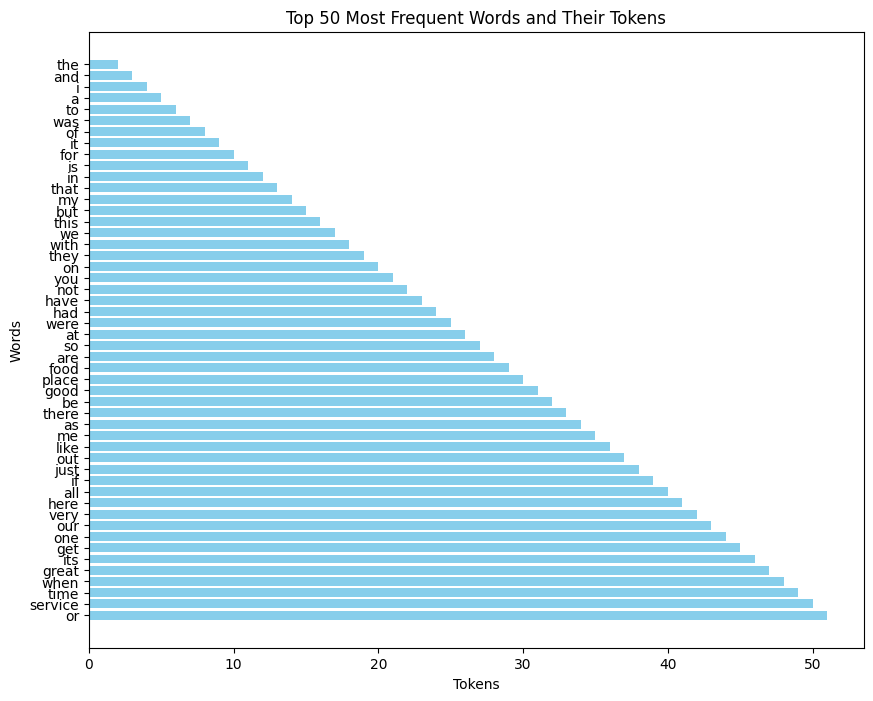

In [ ]:
import matplotlib.pyplot as plt

# Getting the top 50 words and tokens
top_50_words = list(sorted_word_to_token.keys())[:50] # retrieving all the keys (words) from the dictionary
top_50_tokens = [tokenizer.word_index[word] for word in top_50_words]

# Plotting the data
plt.figure(figsize=(10, 8))
plt.barh(top_50_words, top_50_tokens, color='crimson')
plt.xlabel('Tokens')
plt.ylabel('Words')
plt.title('Top 50 Most Frequent Words and Their Tokens')
plt.gca().invert_yaxis()
plt.show()

# Splitting

The data, X has been defined as the unpunctuated 'X_no_punct'.
The labels have been defined as the 'class_index' column.

The dataset has been split into four parts:
- training data, x_train
- the corresponding training labels, y_train
- testing data, x_test
- the corresponding testing labels, y_test
Random state = 42 has been set to ensure the same results everytime I run the code.

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_no_punct, y, test_size = 0.2, random_state = 42)

# Padding
Padding is the process of ensuring that all sequences have the same length by adding special tokens (such as, <"PAD">). Padding is important because LSTMs reqire fixed length. Padding ensures that all input sequences have the same length.

### Padding Training Data
Converting x_train sentences into sequences of integers, and applying padding:

In [ ]:
#padding
sequences = tokenizer.texts_to_sequences(x_train)
padded_sequences = pad_sequences(sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type)

### Padding Test Data
Converting x_test sentences into sequences of integers, and applying padding

In [ ]:
sequences_test = tokenizer.texts_to_sequences(x_test)
padded_sequences_test = pad_sequences(sequences_test, maxlen = max_length, padding = padding_type, truncating = trunc_type)

# Model Building

Initializing the parameters required in the LSTM model.
- 'embedding dim' (embedding dimension) determines the size of the vector to represent each word.
- drop_value is the dropout rate, which is the probability chosen for dropout regularization. The chosen rate is 0.2.
- n_dense is the number of dense or fully connected layers in the network. The number of layers chosen in this analysis was 5. This is because this is a multiclass classification problem and the number of fully connected layers must correspond to the number of classes, which is 5.

In [ ]:
#parameters
vocab_size = 1000
embedding_dim = 16
drop_value = 0.2
n_dense = 5

Building an LSTM model:
The architecture of an LSTM model is as follows:
- ***Sequential()*** is used to define a sequential model, eg. LSTM.

- **model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))** adds an embedding layer. This layer is responsible for word embedding, where words are represented as dense vectors.
   - 'input_length' is the length of the input sequences.

- **model.add(LSTM(30))** adds an LSTM layer with 30 nodes.

- **model.add(Dropout(drop_value))** adds a dropout layer with a specified probability (drop_value) to prevent overfitting.

- **model.add(Dense(n_dense, activation='softmax'))** adds a dense layer with 'n_dense' nodes and a softmax activation function. This is the output layer for multi-class classification.

In [ ]:
# Build the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GlobalAveragePooling1D, Dense, Dropout
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(LSTM(30))
model.add(Dropout(drop_value))
model.add(Dense(n_dense, activation='softmax'))  # Output layer with 2 units (binary classification)
import tensorflow as tf
tf.random.set_seed(42)

# Display the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 16)           16000     
                                                                 
 lstm (LSTM)                 (None, 30)                5640      
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 5)                 155       
                                                                 
Total params: 21795 (85.14 KB)
Trainable params: 21795 (85.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Compile Model

Model compiling is preparing the model for training. Here, additional settings are specified, such as choosing an optimization algoritthm, defining a loss function and setting metrics. We first specify the minimizing optimizer to be used for gradient descent. Then we specify the loss function to be minimized during gradient descent.

The optimizer used for gradient descent in this analysis is the Adam optimizer.  What Adam Optimizer does is it helps specify the method for updating the model's weights 
- **.Adam(clipvalue=1.0)** creates an Adam optimizer with a clip value of 1.0. The clipvalue parameter is used to control gradient clipping, which helps prevent gradients from becoming too large during training
- The loss function is the function to be minimsed during training, and **loss='categorical_crossentropy'** specifies the loss function to be categorical cross-entropy, which is commonly used for multiclass classification problems (Kumar, 2020)

In [ ]:
import keras
from keras.optimizers import Adam
opt = keras.optimizers.Adam(clipvalue=1.0)
model.compile(loss='categorical_crossentropy', optimizer= opt, metrics=['accuracy'])

# Fit Model

One-hot encoding y_test into Y_test and y_train into Y_train.
- The reason is that y_test and y_train are one dimensional and `model.fit()` requires that they have a dimension similar to the number of categories in the target variable. Thus, y_test and y_train need to be one hot encoded into the appropriate number of columns.

In [ ]:
#convert shapes
import tensorflow as tf
Y_train = tf.one_hot(y_train, 5)


In [ ]:
Y_test = tf.one_hot(y_test, 5)

## Defining an earlystopping callback using Tensorflow.

Early stopping is a technique used to prevent overfitting and improve efficiency during the training process. It involves monitoring a specified metric and stopping the training once the metric stops improving or begins to worsen. The metric I will monitor will be validation loss and the training will stop after 10 epochs as follows:

- **monitor=val_loss** specifies that the callback should monitor the validation loss in order to decide whether to stop training.
- **patience =10** means that training should stop if the validation loss has not improved after 10 epochs

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=10)

In [ ]:
#fit
history = model.fit(padded_sequences, Y_train, epochs = 100, batch_size= 512,validation_data =(padded_sequences_test, Y_test),callbacks = [early_stop])

Epoch 1/100
102/102 [==============================] - 31s 280ms/step - loss: 1.6032 - accuracy: 0.2137 - val_loss: 1.5340 - val_accuracy: 0.2908
Epoch 2/100
102/102 [==============================] - 27s 263ms/step - loss: 1.4719 - accuracy: 0.3195 - val_loss: 1.3882 - val_accuracy: 0.3625
Epoch 3/100
102/102 [==============================] - 25s 243ms/step - loss: 1.3379 - accuracy: 0.3717 - val_loss: 1.2856 - val_accuracy: 0.4024
Epoch 4/100
102/102 [==============================] - 25s 242ms/step - loss: 1.2764 - accuracy: 0.4026 - val_loss: 1.2620 - val_accuracy: 0.4205
Epoch 5/100
102/102 [==============================] - 26s 255ms/step - loss: 1.2603 - accuracy: 0.4169 - val_loss: 1.2549 - val_accuracy: 0.4302
Epoch 6/100
102/102 [==============================] - 26s 251ms/step - loss: 1.2442 - accuracy: 0.4248 - val_loss: 1.2323 - val_accuracy: 0.4351
Epoch 7/100
102/102 [==============================] - 25s 249ms/step - loss: 1.2269 - accuracy: 0.4389 - val_loss: 1.2305 -

Looking at the log of training and validation results, I can see the following:

- The training and validation losses fluctuate across epochs, showing variations in the model's performance on both training and unseen validation data.
- Training accuracy starts around 20% and increases over epochs. It then fluctuates around the early 50s and doesn't see a substantial increase.
- Validation accuracy starts around 29% and also increases gradually, fluctuating around the early 50s.
- The validation loss is slightly higher than the training loss throughout the epochs, suggesting a small amount of overfitting.
- The validation accuracy is consistently lower than the training accuracy. This reinforces my suspicions of overfitting.


# Predict

I will be making predictions using the predict() function.

## Training Predictions

In [ ]:
train_pred = model.predict(padded_sequences)

1625/1625 [==============================] - 24s 15ms/step


In [ ]:
train_pred

array([[0.02723795, 0.26917648, 0.5587458 , 0.12920874, 0.01563102],
       [0.6442056 , 0.27955776, 0.05214501, 0.01135809, 0.01273354],
       [0.4118921 , 0.22969799, 0.10903321, 0.09030913, 0.15906745],
       ...,
       [0.19645607, 0.28260437, 0.24267276, 0.15942943, 0.11883752],
       [0.11696899, 0.10856972, 0.12470017, 0.24984758, 0.39991355],
       [0.00092759, 0.00462309, 0.05600976, 0.50876266, 0.42967686]],
      dtype=float32)

Keras predict returns probabilities as classification output (desertnaut, 2017), as shown in the output above.

## Test Predictions

In [ ]:
test_pred = model.predict(padded_sequences_test)

407/407 [==============================] - 7s 15ms/step


In [ ]:
test_pred

## Visualizing Predictions

I will be displaying predictions to compare True Values and Predicted Values.
- I will be using np.argmax() to convert the classification probabilities into actual predicted values:

In [ ]:
import pandas as pd
results_df = pd.DataFrame() #Creating a dataframe to compare predictions
results_df['True Values'] = y_test
results_df['Predicted Values'] = np.argmax(test_pred, axis=1)
results_df_sorted= results_df.sort_index() # Sorting the dataframe rows by index
results_df_sorted.tail(15)

,True Values,Predicted Values
649420,0,2
649467,2,2
649526,0,0
649531,1,0
649616,2,2
649684,4,4
649703,2,3
649765,4,3
649795,3,0
649820,1,1


# Evaluate & Interpret Results

## Validation and Training Loss & Accuracy


I will be calculating the validation and Training Loss & Accuracy metrics for analyzing the performance and progress of a model. I will do this using the evaluate() method.

In [ ]:
accuracy = model.evaluate(padded_sequences_test, Y_test)

407/407 [==============================] - 6s 15ms/step - loss: 1.1181 - accuracy: 0.5140


In [ ]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accuracy[0],accuracy[1]))

Test set
  Loss: 1.118
  Accuracy: 0.514


- This indicates that the model achieved a loss of approximately 1.1 on the test data. This tells us that the difference between the actual data and predicted data is very high.
- The accuracy of 51% means that the model correctly predicted the class labels for about 51% of the test samples.

- The loss value is quite high and the accuracy is quite low. Thus, the model needs some improvement.

## Test vs Train Accuracy

I will compare the test and train accuracy

In [ ]:
from sklearn.metrics import accuracy_score
test_accuracy = accuracy_score(y_test, np.argmax(test_pred, axis=1))
train_accuracy = accuracy_score(y_train, np.argmax(train_pred, axis=1))
acc_results = pd.DataFrame({'Training Accuracy':[train_accuracy],
                           'Testing Accuracy':[test_accuracy]})
acc_results

,Training Accuracy,Testing Accuracy
0,0.543942,0.514


- A training accuracy of 54% means that during the training phase, the model correctly predicted approximately 54.4% of the ratings associated with the training data.
- A test accuracy of 51%  indicates that when the model was evaluated on a separate dataset (the testing dataset), it correctly predicted about 51.4% of the ratings for reviews.
- The testing accuracy is slightly larger than training accuracy indicating that the model is slightly overfitting.
- Although the model is learning from the training data and achieving a moderate level of accuracy, the model needs to be improve to address overfitting on training data and improve generalization on unseen data.

## Confusion Matrix

I will be creating a confusion matrix to understand my predictions better. While the accuracy and loss gave us information about the overall prediction ability of the model, the confusion matrix gives us more insight than just using the accuracy score. The confusion matrix shows us the proportion of correct or incorrect classifications as follows:

1. The number of True Positives (TP)
2. The number of False Positives (FP)
3. The number of False Negatives (FN)
4. The number of True Negatives (TN)

- TP: The model correctly predicted a review as belonging to a certain star rating
- FP: The model incorrectly predicted a review as belonging to a certain star rating when it does not
- FN: The model incorrectly predicted a review as not belonging to a certain star rating when it does
- TN: The model correctly predicted a review as not belonging to a certain star rating

array([[1574,  607,  144,   86,  193],
       [ 531, 1109,  628,  223,  167],
       [  95,  518, 1015,  672,  265],
       [  47,   94,  479, 1213,  789],
       [  49,   43,   94,  594, 1771]])

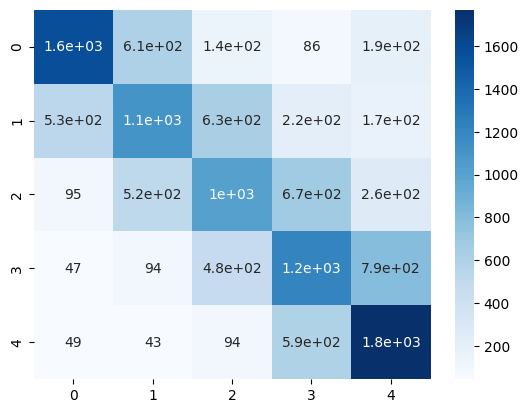

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, np.argmax(test_pred, axis=1), labels=range(5))
sns.heatmap(cm, annot=True, cmap="Blues") #creating a heatmap
cm

Classes 0 and 4 have the highest true positives, indicating that it's easier for the model effectively discern between extremely negative and positive sentiments, leading to accurate classification.
- Class 1 shows a high number of instances classified as either 0 or 2, which makes sense since classes 1 and 2 are close in terms of sentiment. Moreover,
- Class 2 has a high number of reviews categorized as either class 1 or 3.
- Class 3 has a high number of instances classified as class 4, and vice versa, most likely due to the similarity in sentiment between these classes.

Since, classes 0 and 4 represent the strongest sentiment levels, they are easily identifiable, thus resulting in high true positive rates. Conversely, classes 1, 2, and 3 could be easily confused with each other, given their more nuanced sentiment differences.

## Classification Report

I will calculate the Classification report. The advantage of the classification report is that it provides a summary of the model's performance across different classes, according to the metrics of precision, recall, and F1-score.

The classification report uses the results of the confusion matrix.
- Precision is the ratio of the number of samples actually belonging to the positive class and all the samples that were predicted to be of the positive class.
Precision= True Positives/(False Positives+True Positives)

- Recall is the ratio of the number of samples predicted correctly to be belonging to the positive class and all the samples that actually belong to the positive class.
Recall = True Positives/(False Negatives+True Positives)
- f1 Score is the harmonic mean of the recall and precision scores from the positive class. The f1-score takes into account both the precision and recall, and a high f1-score (closer to 1) implies that both the precision and recall are high.

In [ ]:
from sklearn.metrics import classification_report
cr = classification_report(y_test, np.argmax(test_pred, axis=1))
print(cr)

              precision    recall  f1-score   support

           0       0.69      0.60      0.64      2604
           1       0.47      0.42      0.44      2658
           2       0.43      0.40      0.41      2565
           3       0.44      0.46      0.45      2622
           4       0.56      0.69      0.62      2551

    accuracy                           0.51     13000
   macro avg       0.51      0.51      0.51     13000
weighted avg       0.51      0.51      0.51     13000



Visualizing the classification Report

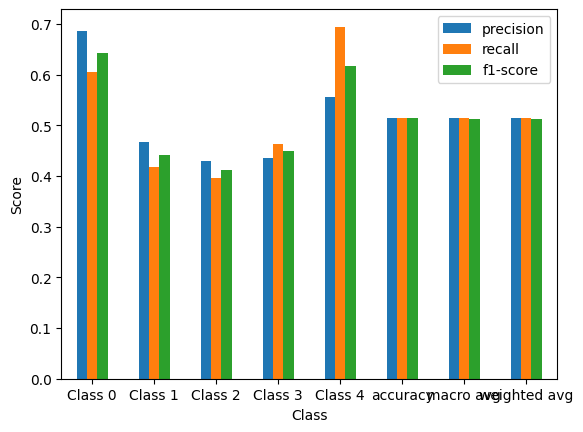

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Creating classification report
report_cr = classification_report(y_test, np.argmax(test_pred,axis=1), target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'], output_dict=True)

# Converting the classification report to a Dataframe for visualization
df_report = pd.DataFrame(report_cr).transpose()

# Plotting precision, recall, and F1-score for each class
df_report[['precision', 'recall', 'f1-score']].plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()

Precision is the count of values predicted as positive that are actually positive. In the context of reviews, it represents the number of reviews classified as a specific rating that accurately match that rating. Recall is the actual count of positive instances correctly predicted as positive. In terms of reviews, it signifies the number of reviews truly belonging to a class that were predicted accurately for that class. The F1 Score is the average combination of recall and precision, portraying the overall accuracy of the model.

Classes 0 and 4 show the highest precision and recall and consequently, the highest F1 score. This makes sense as classes 0 and 4 represent the strongest levels of sentiment, making them easier to classify. Conversely, the remaining classes show low to moderate precision and recall values. Also, the average precision and recall for the entire model are moderate, hovering around 50%. This implies that the reviews were accurately classified only 50% of the time, thus emphasising the need for model enhancement.

# Visualization of Results

## Validation and Training Loss & Accuracy Graph
I will be craeting loss and validation curves. Validation and Training Loss & Accuracy Graphs will help me analyze the performance and progress of a model during training. The graph typically displays two key metrics: loss and accuracy.

- The loss shows the difference between the predicted values and actual values
- The accuracy tells us about the overall accuracy of predictions.

- Training Loss: Shows us how well the model fits on the training data (Baeldung, 2023).

- Validation Loss: Shows us how well the model is generalizing.

- Training Accuracy: Shows the accuracy on the training data.

- Validation Accuracy: Shows the accuracy on the test dataset.



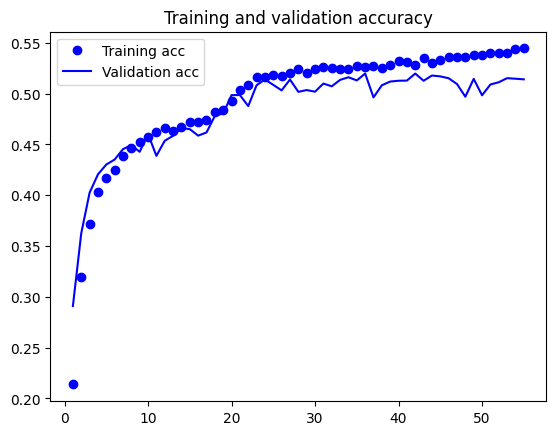

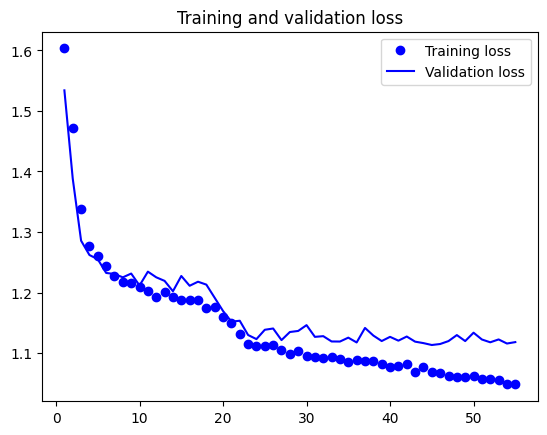

In [ ]:
import matplotlib.pyplot as plt
# Extracting accuracy and loss values from the training history
acc = history.history['accuracy'] # extracting training accuracy values
val_acc = history.history['val_accuracy'] # extracting validation accuracy values
loss = history.history['loss'] # extracting training loss values
val_loss = history.history['val_loss'] # extracting validation loss values

# Generating a range of epochs for plotting
epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plotting training and validation loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

#Code adapted from: https://www.kaggle.com/code/ngyptr/multi-class-classification-with-lstm

### **Accuracy Curves:**
Accuracy represents the number of correct predictions made by the model. The accuracy curve above indicate the number of correct predictions made by the model.

- In the above accuracy curves, it can be seen that the training accuracy curve is slightly higher than the validation accuracy, with a considerable gap between the two curves. This indicates that there could be overfitting in the model.
- The training accuracy shows a steady rise, while the validation accuracy seemingly fluctuates around 55%. Both the loss nd accuracy curves have fluctuations. These fluctuations further hint at problems with overfitting and also with possible gradient explosion. These fluctuations could also hint to the dataset being to small, this is given by the dataset having been subsetted by 10% to 65000.


### **Loss Curves:**
Training loss is the difference between predicted and actual values during the training. Validation loss is the difference between actual and predicted values during testing.
- In the above curve it can be seen that the training loss is decreasing, while the validation loss is fluctuating around 1.1. This could be indicative of overfitting in the model.

The fluctuations could suggest the following issues:

- Low Learning Rate - A very low learning rate may cause convergence to take a long time (Zvornicanin, 2022), and the loss curve may look to have small fluctuations due to tiny steps towards the minimum.
- Small Batch Size - A small batch size means that each update to the model's weights is based on a small subset of the data. This can lead to noise into the learning process and this can result in fluctuations in the loss curve (xboard, 2018).
-If gradients become too large during training (gradient explosion),this can cause spikes in the loss.

## ROC Curve

I will be creating an ROC curve to analyze the data.

The Receiver Operating Characteristic (ROC) curve is used for evaluating the performance of a classification model.

The plot shows the relationship between the true positive rate (TPR) and the false positive rate (FPR).

- A high TPR indicates that the model is good at identifying true positives.

- A low FPR indicates that the model is good at not falsely labeling negatives as positives.

The ROC curve is plotted with TPR on the y-axis and FPR on the x-axis. An ideal ROC curve is one that hugs the top-left corner of the plot, because this would indicate high TPR and low FPR.

Along with the ROC curve, the area under the ROC curve (AUC) is a  metric used to determine the model's performance. AUC outputs a single numerical value, which represents the model's ability to discriminate between positive and negative samples. The AUC is measured between 0 and 1. A higher AUC (closer to 1) indicates better performance.

The ROC is typically used for evaluating the performance of a binary classification model. However, in this analysis it was used to evaluate the performance of a multiclass classification model.

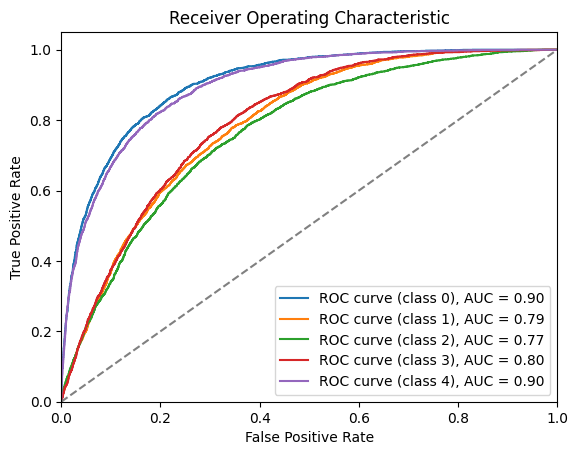

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarizing the labels
y_true_binarized = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

# Computing ROC curve and ROC area for each class
fpr = dict() #false positive rate
tpr = dict() #true positive rate
roc_auc = dict() #auc
n_classes = y_true_binarized.shape[1] #number of classes

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC curve for each class
plt.figure()

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}), AUC = {roc_auc[i]:.2f}')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Code adapted from: https://www.statology.org/plot-multiple-roc-curves-python/;
# https://stackoverflow.com/a/70002535;
# https://www.geeksforgeeks.org/multiclass-receiver-operating-characteristic-roc-in-scikit-learn/

### **ROC Curve**
- Ideally, ROC plots should hug the corner, showing true positive rates on the y-axis and false positive rates on the x-axis. Hugging the corner indicates a high true positive rate and a low false positive rate.
- Both classes 0 and 4 hug the corner, meaning that they have high true positive rates and low false positive rates.
- The other classes, as shown by the graph have a lower true positive rate and higher false positive rate.

### **AUC Metric**
- The AUC score quantifies the ROC curve. It shows how well a ceratin class has been predicted by the model. A higher AUC score implies better generalization, with increased true positives and decreased false positive rates.
- Class 0 and 4 perform the best, having a high AUC of 0.9, being the best predicted classes.
- On the contrary, class 2 performs the worst, achieving an AUC of 0.77, and being the worst predicted class.
- Despite classes 1, 2, and 3 having lower AUCs compared to classes 0 and 4, their AUC scores are relatively high, showing that the model has been able to decently predict these classes.
- All classes have AUCs ranging between 0.77 and 0.90, showing that they are they have been well predicted.
- The most accurately predicted classes are class 0 and 4, which is logical given that identifying and categorizing strong positive and negative sentiments tends to be straightforward. In contrast, the more subtle sentiments represented by classes 1, 2, and 3 can be easily mistaken for one another, and thus they haven't been predicted as accurately.


#Hyperparameter Tuning

I will be performing hyperparameter tuning in order to improve my model. Specifically, I will be focusing on adjusting batch size, learning rate, clip value, and dropout rate. This decision is driven by the following considerations:

- There were some spikes observed  in the Loss and Accuracy curves and the occurence of these spikes suggests that either the learning rate or batch size may be too high, resulting in these fluctuations. As a result, I am prioritizing tuning the learning rates and batch sizes.

- The presence of spikes also hints at pothe possibility of gradient explosion issues. To address this issue, I will be tuning the clip value.

- The validation loss is slightly larger than the training loss, and this indicates that there could be overfitting. Thus, I will be fine-tuning the dropout rate to mitigate this possible overfitting.

I will be performing tuning using for loops, rather than gridsearch.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
tf.random.set_seed(42)

# Defining the LSTM model function with gradient clipping
def create_model(learning_rate=0.001, dropout_rate=0.2, clip_norm=1.0):
    model_ht = Sequential()
    model_ht.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model_ht.add(LSTM(30))
    model_ht.add(Dropout(dropout_rate))
    model_ht.add(Dense(n_classes, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model_ht.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model_ht

# Defining hyperparameters to tune
param_grid = {
    'batch_size': [16, 32, 512],
    'learning_rate': [0.001, 0.01],
    'dropout_rate': [0.1, 0.3],
    'clip_norm': [0.1, 0.2,1.0]  # Add clip_norm for tuning
}

best_model = None
best_score = 0.0

# Iterating over hyperparameters
for batch_size in param_grid['batch_size']:
    for learning_rate in param_grid['learning_rate']:
        for dropout_rate in param_grid['dropout_rate']:
            for clip_norm in param_grid['clip_norm']:
                # Creating and compiling the model
                model_ht = create_model(learning_rate, dropout_rate, clip_norm)

                # Training the model
                model_ht.fit(padded_sequences, y_train, epochs=1, batch_size=batch_size, validation_data=(padded_sequences_test, y_test))


                # Evaluating on validation data
                _, accuracy = model_ht.evaluate(padded_sequences_test, y_test)

                # Updating the best model and score
                if accuracy > best_score:
                    best_model = model_ht
                    best_score = accuracy
                    best_batch_size = batch_size
                    best_learning_rate = learning_rate
                    best_dropout_rate = dropout_rate
                    best_clip = clip_norm

# Printing the best model's architecture and score

best_model.summary()

407/407 [==============================] - 7s 16ms/step - loss: 1.6047 - accuracy: 0.2197
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 200, 16)           16000     
                                                                 
 lstm_21 (LSTM)              (None, 30)                5640      
                                                                 
 dropout_21 (Dropout)        (None, 30)                0         
                                                                 
 dense_21 (Dense)            (None, 5)                 155       
                                                                 
Total params: 21795 (85.14 KB)
Trainable params: 21795 (85.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Printing Best Parameters

In [ ]:
# Print the best model's architecture and score
print("Best model architecture:")
print("Best validation accuracy:", best_score)
print("Best batch Size:", best_batch_size)
print("Best Learning Rate:", best_learning_rate)
print("Best clip value", best_clip)
print("Best Dropout_rate", best_dropout_rate)

Best model architecture:
Best validation accuracy: 0.4445384740829468
Best batch Size: 32
Best Learning Rate: 0.01
Best clip value 1.0
Best Dropout_rate 0.1


#Retrain Model

I will be retraining the original model using the new values:
- clip value: 1.0
- dropout rate: 0.1
- batch size: 32
- learning rate: 0.01




In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
tf.random.set_seed(42)

vocab_size = 10000
embedding_dim = 16
max_length = 200

# Using the original model
model_re = Sequential()
model_re.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model_re.add(LSTM(30))
model_re.add(Dropout(best_dropout_rate))
model_re.add(Dense(n_classes, activation='softmax'))

# Compiling the model
optimizer = Adam(learning_rate=best_learning_rate, clipvalue = best_clip)
model_re.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Training the model
retrained = model_re.fit(padded_sequences, y_train, epochs=100, batch_size=best_batch_size, validation_data=(padded_sequences_test, y_test), callbacks=[early_stop])


Epoch 1/100
1625/1625 [==============================] - 84s 51ms/step - loss: 1.6079 - accuracy: 0.2100 - val_loss: 1.6035 - val_accuracy: 0.2135
Epoch 2/100
1625/1625 [==============================] - 83s 51ms/step - loss: 1.3260 - accuracy: 0.3934 - val_loss: 1.1742 - val_accuracy: 0.4807
Epoch 3/100
1625/1625 [==============================] - 84s 52ms/step - loss: 1.1518 - accuracy: 0.4957 - val_loss: 1.1333 - val_accuracy: 0.5066
Epoch 4/100
1625/1625 [==============================] - 82s 50ms/step - loss: 1.1076 - accuracy: 0.5181 - val_loss: 1.1172 - val_accuracy: 0.5168
Epoch 5/100
1625/1625 [==============================] - 81s 50ms/step - loss: 1.0846 - accuracy: 0.5272 - val_loss: 1.1152 - val_accuracy: 0.5125
Epoch 6/100
1625/1625 [==============================] - 80s 49ms/step - loss: 1.0651 - accuracy: 0.5372 - val_loss: 1.1332 - val_accuracy: 0.5097
Epoch 7/100
1625/1625 [==============================] - 81s 50ms/step - loss: 1.0521 - accuracy: 0.5431 - val_loss: 1

## Loss/Accuracy Curves

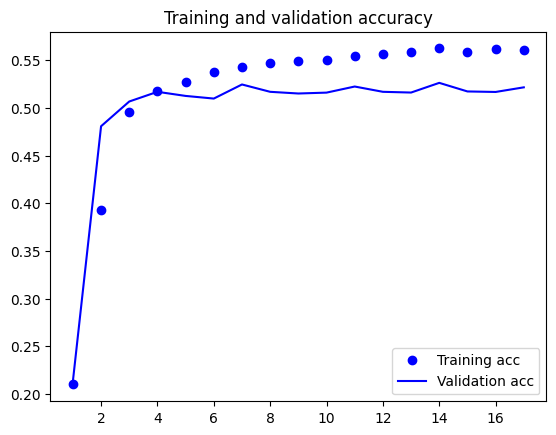

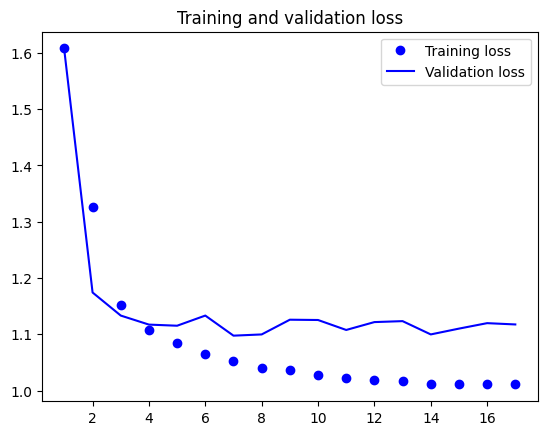

In [ ]:
import matplotlib.pyplot as plt

# Extracting accuracy and loss values from the retrained model training history
acc1 = retrained.history['accuracy']
val_acc1 = retrained.history['val_accuracy']
loss1 = retrained.history['loss']
val_loss1 = retrained.history['val_loss']

# Generating a range of epochs for plotting for retrained model
epochs1 = range(1, len(acc1) + 1)

# Plotting training and validation accuracy for retrained model
plt.plot(epochs1, acc1, 'bo', label='Training acc')
plt.plot(epochs1, val_acc1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plotting training and validation loss for retrained model
plt.plot(epochs1, loss1, 'bo', label='Training loss')
plt.plot(epochs1, val_loss1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

- The fluctuations appear to be flatter, this could be due to the gradient clipping
-The fluctuations are still visible, this could be because a small learning rate was chosen as the best learning rate. It could also be because the best batch size was chosen to be a small one, batch_size=32, which lead to fluctuations in the data.
- Even after applying the optimal parameters, the curve is still displaying signs of overfitting. As the training loss decreases, the validation loss appears to increase.
- In fact the level of overfitting appears to have increased as the train accuracy is not a lot larger than the test accuracy, compared to the previous model, as shown in the training and validation accuracy below:

## Training and Validation Accuracy

In [ ]:
from sklearn.metrics import accuracy_score
print("Test accuracy:", accuracy_score((y_test), np.argmax((model_re.predict(padded_sequences_test)), axis=1)))
print("Training accuracy:", accuracy_score(y_train, np.argmax(model_re.predict(padded_sequences), axis=1)))

407/407 [==============================] - 7s 17ms/step
Test accuracy: 0.5214615384615384
1625/1625 [==============================] - 26s 16ms/step
Training accuracy: 0.5821923076923077


The train accuracy is much larger than the test accuracy, pointing to overfitting. The overfitting seems to have increased from the previous model, with a larger gap between the training and validation data. This could be due to the limited number of epochs, with early_stop cutting the number of epochs to 17, compared to the 55 epochs in the first model. There could also be a need to add more regularization.

## Validation Loss and Accuracy

In [ ]:
accuracy_re = model_re.evaluate(padded_sequences_test, y_test)

407/407 [==============================] - 6s 16ms/step - loss: 1.1175 - accuracy: 0.5215


1. **Loss**:
   - The loss value measures how well the machine learning model performs during training.
   - A loss of 1.117 in high and thus indicates that the model did not perform well during training.It shows that the predicted values from the model differ from the actual values on average by this amount. Thus, the difference is quite high.

2. **Accuracy**:
   - Accuracy represents the proportion of reviews which have been correctly classified out of the total reviews.
   - An accuracy of 0.52 means that the model correctly predicts the class 52% of the time. This means that the model has a moderate level of accuracy.

3. The loss and accuracy of the retrained model have changed just slightly compared to the original model. In fact, there is not much of a difference. The accuracy has increased, but this increase is negligible.

## ROC Curve

In [ ]:
re_train = model_re.predict(padded_sequences) #making train predictions

1625/1625 [==============================] - 25s 15ms/step


In [ ]:
re_test = model_re.predict(padded_sequences_test) #making test predictions

407/407 [==============================] - 6s 15ms/step


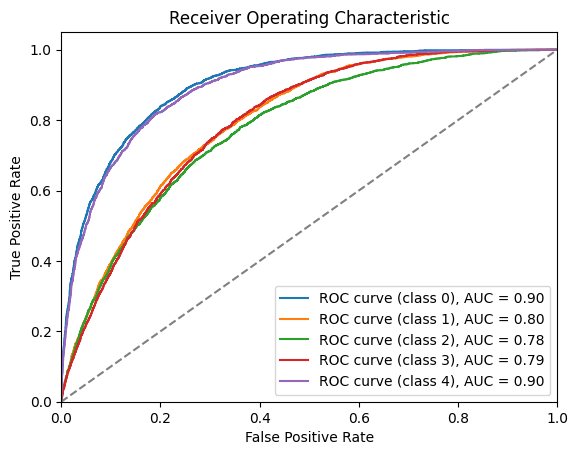

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(42)

# Binarizing the labels
y_true_binarized1 = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

# Computing ROC curve and ROC area for each class
fpr1 = dict()
tpr1 = dict()
roc_auc1 = dict()
n_classes1 = y_true_binarized.shape[1]

for i in range(n_classes1):
    fpr1[i], tpr1[i], _ = roc_curve(y_true_binarized1[:, i], re_test[:, i])
    roc_auc1[i] = auc(fpr1[i], tpr1[i])

# Plotting ROC curve for each class
plt.figure()

for i in range(n_classes):
    plt.plot(fpr1[i], tpr1[i], label=f'ROC curve (class {i}), AUC = {roc_auc1[i]:.2f}')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


- Class 0 and 4 are still the best predicted classes, with the same AUC as the original model.
- The rest of the AUC values remained almost the same from the previous model. They have changed just by one percent, whith is not much of a difference.

## Classification Report

In [ ]:
from sklearn.metrics import classification_report
cr_re = classification_report(y_test, np.argmax(re_test, axis=1))
print(cr_re)

              precision    recall  f1-score   support

           0       0.58      0.70      0.64      2604
           1       0.46      0.48      0.47      2658
           2       0.45      0.43      0.44      2565
           3       0.46      0.39      0.42      2622
           4       0.63      0.61      0.62      2551

    accuracy                           0.52     13000
   macro avg       0.52      0.52      0.52     13000
weighted avg       0.52      0.52      0.52     13000



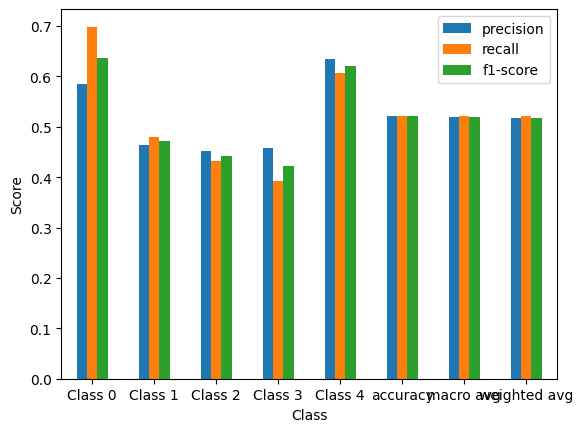

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

report_cre = classification_report(y_test, np.argmax(re_test,axis=1), target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'], output_dict=True)

# Convert the classification report to a DataFrame for visualization
df_report_re = pd.DataFrame(report_cre).transpose()

# Plotting precision, recall, and F1-score for each class
df_report_re[['precision', 'recall', 'f1-score']].plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()

- As in the original model, classes 0 and 4 have the highest precision and recall, with classes 1, 2 and 3 being in between.
- However, the precision in class 0 has decreased
- In class 4, the recall has increased
- The average overall accuracy for all the classes, however, has increased by 1%, which is a negligible change.

## Confusion Matrix

array([[1819,  587,  103,   41,   54],
       [ 724, 1277,  478,  114,   65],
       [ 238,  643, 1110,  436,  138],
       [ 153,  175,  632, 1027,  635],
       [ 179,   72,  129,  625, 1546]])

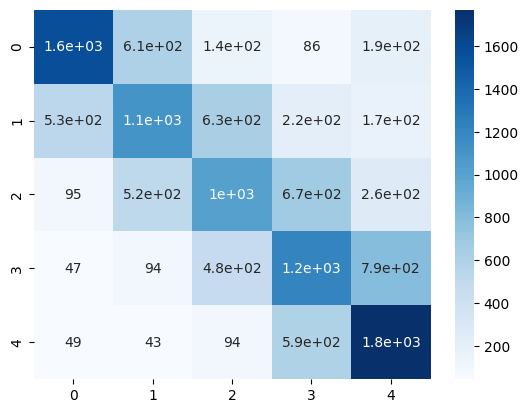

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cf=confusion_matrix(y_test, np.argmax(re_test, axis=1), labels=range(5)) #using the actual and predicted train values
sns.heatmap(cm, annot=True, cmap="Blues")
cf

- The best predicted models are still 0 and 4, having the highest true positive values.
-  A high number of reviews belonging to class 1 have been classified as class 0.
- A high number of reviews belonging to class 2 have been classified as class 1.
- A high number of reviews belonging to class 3 have been classified as class 2.
- A high number of reviews belonging to class 4 have been classified as class 3.
- These make sense since these classes are next to each other and are thus similar in sentiment.
- The overall number of true positives are quite high and close to one another.
- This has not changed much from the original model

# Compare results

Comparing the loss and accuracy results of the original and retrained data, using a loss and accuracy curves.
I will be using subplots to plot the loss/accuracy curves for the original and retrained model. [kaggle.com/mnpatha1](https://www.kaggle.com/code/mnpathak1/model-comparison-with-roc-curves-and-more) 

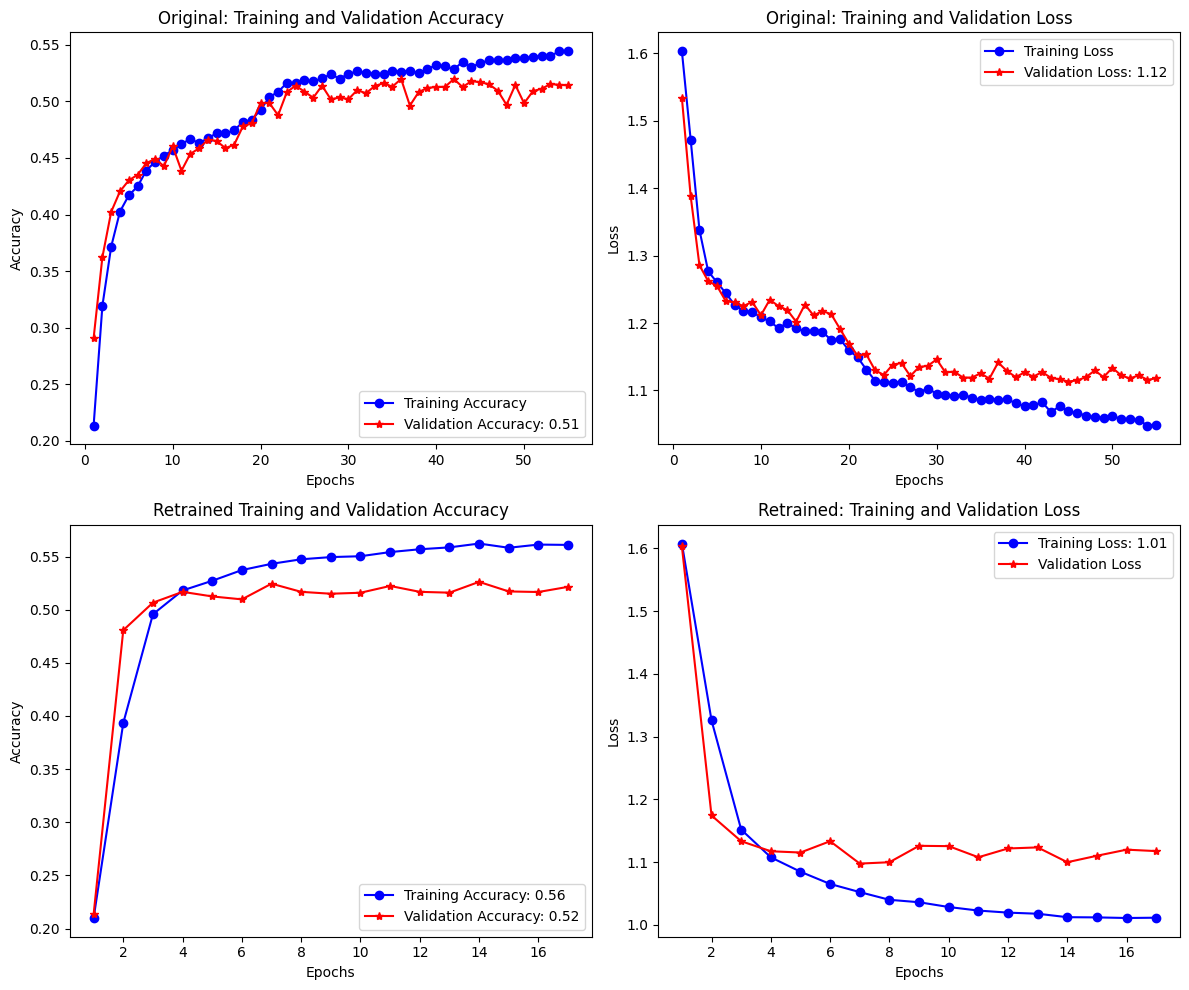

In [ ]:
import matplotlib.pyplot as plt

# Sample data for Original and retrained models
epochs1 = range(1, len(acc) + 1)
epochs2 = range(1, len(acc1) + 1)
# Create subplots for the two sets
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Creating plot for accuracy in the Original model
axs[0, 0].plot(epochs1, acc, 'bo-', label='Training Accuracy')
axs[0, 0].plot(epochs1, val_acc, 'r*-', label=f'Validation Accuracy: {val_acc[-1]:.2f}')
axs[0, 0].set_title('Original: Training and Validation Accuracy')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()
#{val_acc1[-1]:.2f}: displays the last value ([-1]) from the val_acc1 list (presumably a list of validation accuracies) with two decimal places (.2f).

# Creating plot for loss in the Original model
axs[0, 1].plot(epochs1, loss, 'bo-', label='Training Loss')
axs[0, 1].plot(epochs1, val_loss, 'r*-', label=f'Validation Loss: {val_loss[-1]:.2f}')
axs[0, 1].set_title('Original: Training and Validation Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()

# Creating plot for accuracy in the Retrained model
axs[1, 0].plot(epochs2, acc1, 'bo-', label=f'Training Accuracy: {acc1[-1]:.2f}')
axs[1, 0].plot(epochs2, val_acc1, 'r*-', label=f'Validation Accuracy: {val_acc1[-1]:.2f}')
axs[1, 0].set_title('Retrained Training and Validation Accuracy')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].legend()

# Creating plot for loss in the Retrained model
axs[1, 1].plot(epochs2, loss1, 'bo-', label=f'Training Loss: {loss1[-1]:.2f}')
axs[1, 1].plot(epochs2, val_loss1, 'r*-', label='Validation Loss')
axs[1, 1].set_title('Retrained: Training and Validation Loss')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

# Interpreting the Results
### **Original Model**
The training and test accuracies of the model were in the early 50 percents. The training accuracy was slightly higher than the test accuracy, hinting at the possibility of overfitting. This possibility of overfitting can also be seen on the loss curves, where the training loss continues decreasing and the validation loss decreases and starts leveling off.

The results of the ROC curve show that the best predicted classes are class 0, and class 4 both with a AUC of 0.9. This makes sense because identifying and categorizing strong positive and negative sentiments associated wih class 0 (very bad) and class 4 (very good) tend to be straightforward. In contrast, the more subtle sentiments represented by classes 1, 2, and 3 can be easily mistaken for one another.

The fact that class 0 and 4 are the best predicted is shown by the fact that they have the highest number of true positives. This is shown on the confusion matrix where class 0 and class 4 have the highest number of true positives, which is the highest number of reviews accurately classified into those specific classes. This means that out of all the reviews classified as postive, classes 0 and 4 have the highest number of accurate classifications.

Class 0 and 4 not only have the highest number of true positives, but the lowest number of false positives. This is shown on the ROC curve, where classes 0 and 4 hug the top left corner of the plot. The ROC curve measures the true positive rate on the y-axis versus the false positive rate on the x-axis. Thus, class 0 and 4 have a higher true positive rate and a lower false negative rate, while the rest of the classes have a lower true positive rate and higher false positive rate.

As a result, classes 0 and 4 also have the having the highest f1 scores, as well as precision and recall. This means that these categories have a low number of false negative or false positives.

The validation loss curves appear to have fluctuations in them. Thus, this could be due to the overfitting of the model. This could also point to the possibilities that the learning rate may be too high or the batch size too large, possibly resulting in instability during training and causing spikes. Another possibility was that of exploding gradients, causing spikes in the curves.

Since I suspect that exploding gradients, high learning rate and high batch size could be the problem in my results, I would be applying hyperparameter tuning to search for the optimal combination of batch size, learning rate, dropout value and clip value and retraining a model using these new parameters.

### **Retrained Model**

The results of the retrained model show to be slightly higher validation accuracy than the original model. Just like the original model the retrained model has shown signs of overfitting. The training loss is larger than the validation loss, suggesting overfitting. Also, the retrained model seems to have increased in overfitting, as the gap between the training and validation accuracy is larger compared to that of the original model.

The confusion matrix still shows class 0 and 4 to be the best predicted classes, and the average accuracy of the trained dataset increased just by 1% compared to the original dataset. According to the ROC-AUC analysis, classes 0 and 4 still have the highest true positives and lowest false positives.

However, the fluctuations are still showing up in the accuracy and loss curves of the retrained model, in spite of reducing the batch size and learning rate and introducing gradient clipping and regularization. However, they are a lot flatter. This could be due to the effects of gradient clipping. According to an answer on StackOverflow by xboard , spikes or fluctuations are an inevitable result of applying min-batch gradient descent from the Adam Optimizer, which is batch_size =32. According to another answer by John , such spikes are normal and not a cause for concern. He reiterates the idea of mini-batch gradient descent, saying that many algorithms perform gradient descent in small batches. These spikes could thus be a result of the batch size 32 being used as the optimal batch size in the retrained model. However, the original model also had spikes, in spite of having a large batch size. This could have been due to a small learning rate.

All in all, the prediction accuracy of the retrained model appears to be similar to that of the original model. In spite of applying hyperparameter tuning, only a small change has been observed. This could be due to insufficient data, as the data has been subsetted by 10% to 65000. Thus, the dataset may not represent the entire population well, the model may only learn the few available examples, leading to poor generalization. Or perhaps, there may not be enough examples per class, causing the model may struggle to learn distinguishing features for these classes. This could all result in overfitting.

# Shutting Down
Shutting down the spark session using spark.stop()

In [ ]:
spark.stop()